In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive/My Drive/ANDL/Homework_1

/gdrive/My Drive/ANDL/Homework_1


In [4]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 989 kB 9.2 MB/s 


In [5]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import visualkeras
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image

from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator

tfk = tf.keras
tfkl = tf.keras.layers
from tensorflow.python.client import device_lib

tfkl = tf.keras.layers
print(tf.__version__)
tf.test.is_built_with_cuda()

2.9.2


True

In [6]:
#import tensorflow.keras.applications.vgg16 
#from tensorflow.keras.applications.vgg16 import preprocess_input

from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

58889256/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

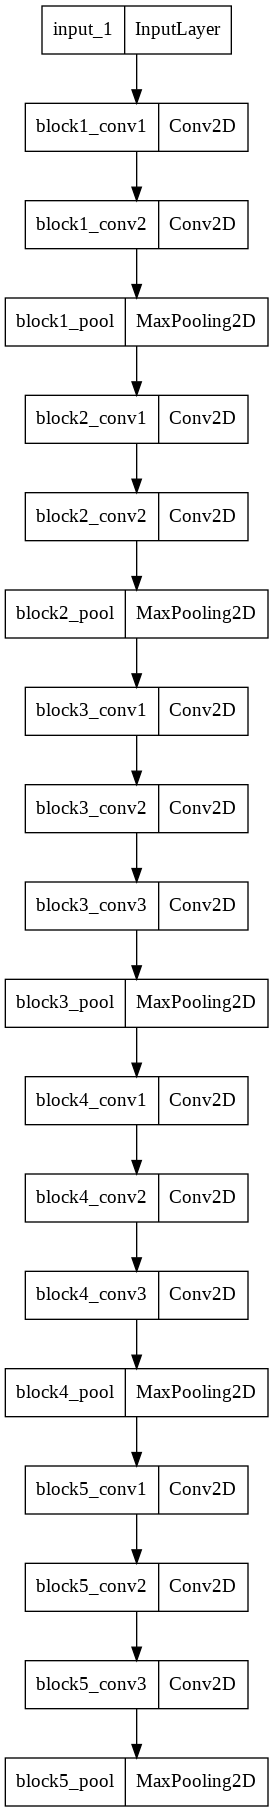

In [7]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(64,64,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [8]:
#set the same seed every time to ensure consistency between the variuos attempts
seed = 42
batchSize = [32, 64, 128, 256]
denseUnits = [128]
dropout1 = 0.3
dropout2 = 0.3
outputUnits = 14
learningRate = 1e-3
gamma = 1e-5

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [9]:
import warnings
import logging

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)
tf.get_logger().setLevel('INFO')
tf.autograph.set_verbosity(0)

tf.get_logger().setLevel(logging.ERROR)
tf.get_logger().setLevel('ERROR')
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

###DB inspection


In [10]:
labels = ['Species1', 'Species2','Species3','Species4','Species5','Species6','Species7','Species8']

# Dataset folders 
dataset_dir = 'atMost200'
training_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'val')
test_dir = os.path.join(dataset_dir, 'test')

# Training with and without data augmentation

In [11]:
#pre processing
trainGen = ImageDataGenerator(
    preprocessing_function= preprocess_input,
                            rotation_range=180,
                            height_shift_range=70,
                            width_shift_range=120,
                            zoom_range=0.3,
                            horizontal_flip=True,
                            vertical_flip=True, 
                            fill_mode='constant',
                            cval=0)

valGen = ImageDataGenerator(
    preprocessing_function=preprocess_input,

)

testGen = ImageDataGenerator(
    preprocessing_function=preprocess_input,

)

noaug_train_gen = trainGen.flow_from_directory(directory=training_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=128,
                                               shuffle=True,
                                               seed=seed)

valid_gen = valGen.flow_from_directory(directory=validation_dir,
                                               target_size=(256,256),
                                               color_mode='rgb',
                                               classes=None,
                                               class_mode='categorical',
                                               batch_size=128,
                                               shuffle=False,
                                               seed=seed)
test_gen = testGen.flow_from_directory(directory=test_dir,
                                             target_size=(256,256),
                                             color_mode='rgb',
                                             classes=None, # can be set to labels
                                             class_mode='categorical',
                                             batch_size=8,
                                             shuffle=False,
                                             seed=seed)

Found 1600 images belonging to 8 classes.
Found 527 images belonging to 8 classes.
Found 361 images belonging to 8 classes.


###Models Metadata
more epochs since interesting validation course

In [12]:
input_shape = (96, 96, 3)
epochs = 50

###CNN model

In [13]:
#Model builder
def build_model(input_shape):

    model = tfk.Sequential()

    inception = InceptionV3(include_top=False, weights="imagenet", input_shape=input_shape)
    inception.trainable = False
    #vgg = tfk.applications.VGG16(include_top=False,weights="imagenet",input_shape=input_shape)
    

    inception.summary()
    for i, layer in enumerate(inception.layers):
        print(i, layer.name)
    #for i, layer in enumerate(vgg.layers):
        #print (i,layer.name)
    model = tfk.Sequential()
    model.add(inception)
    #model.add(vgg)
    model.add(tfkl.GlobalAveragePooling2D())
    model.add(tfkl.Dense(units=512, activation='relu', kernel_initializer=tfk.initializers.GlorotUniform(seed=seed)))
    model.add(tfkl.Dropout(0.3, seed=seed))
    model.add(tfkl.Dense(units=8, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed=seed), name = 'output_layer'))
    model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='categorical_accuracy')

    # Return the model
    return model

In [14]:
# Utility function to create folders and callbacks for training
from datetime import datetime

def create_folders_and_callbacks(model_name):

  exps_dir = os.path.join('data_augmentation_experiments')
  if not os.path.exists(exps_dir):
      os.makedirs(exps_dir)

  now = datetime.now().strftime('%b%d_%H-%M-%S')

  exp_dir = os.path.join(exps_dir, model_name + '_' + str(now))
  if not os.path.exists(exp_dir):
      os.makedirs(exp_dir)
      
  callbacks = []

  # Model checkpoint
  # ----------------
  ckpt_dir = os.path.join(exp_dir, 'ckpts')
  if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)

  ckpt_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(ckpt_dir, 'cp.ckpt'), 
                                                     save_weights_only=True, # True to save only weights
                                                     save_best_only=False) # True to save only the best epoch 
  callbacks.append(ckpt_callback)

  # Visualize Learning on Tensorboard
  # ---------------------------------
  tb_dir = os.path.join(exp_dir, 'tb_logs')
  if not os.path.exists(tb_dir):
      os.makedirs(tb_dir)
      
  # By default shows losses and metrics for both training and validation
  tb_callback = tf.keras.callbacks.TensorBoard(log_dir=tb_dir, 
                                               profile_batch=0,
                                               histogram_freq=1)  # if > 0 (epochs) shows weights histograms
  callbacks.append(tb_callback)

  # Early Stopping
  # --------------
  es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)
  callbacks.append(es_callback)

  return callbacks

87910968/87910968 [==============================] - 1s 0us/step
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 96, 96, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 47, 47, 32)   864         ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 47, 47, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activatio

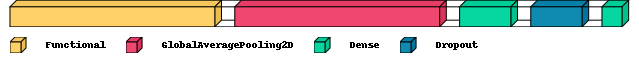

In [15]:
#build model with the input shape and print the summary
model = build_model(input_shape)
model.summary()
#model.get_layer('vgg16').trainable = False
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=10)

In [16]:
# Create folders and callbacks and fit
noaug_callbacks = create_folders_and_callbacks(model_name='CNN_NoAug')

# Train the model
history = model.fit(
    x = noaug_train_gen,
    epochs = epochs,
    validation_data = valid_gen,
    callbacks = noaug_callbacks,
).history

Epoch 1/50
13/13 [==============================] - 506s 39s/step - loss: 2.4572 - categorical_accuracy: 0.1900 - val_loss: 1.9607 - val_categorical_accuracy: 0.2562
Epoch 2/50
13/13 [==============================] - 23s 2s/step - loss: 1.8507 - categorical_accuracy: 0.2788 - val_loss: 1.8144 - val_categorical_accuracy: 0.2391
Epoch 3/50
13/13 [==============================] - 23s 2s/step - loss: 1.7240 - categorical_accuracy: 0.3388 - val_loss: 1.6884 - val_categorical_accuracy: 0.4194
Epoch 4/50
13/13 [==============================] - 23s 2s/step - loss: 1.6298 - categorical_accuracy: 0.3906 - val_loss: 1.6058 - val_categorical_accuracy: 0.4194
Epoch 5/50
13/13 [==============================] - 23s 2s/step - loss: 1.5757 - categorical_accuracy: 0.4175 - val_loss: 1.5489 - val_categorical_accuracy: 0.4611
Epoch 6/50
13/13 [==============================] - 23s 2s/step - loss: 1.5290 - categorical_accuracy: 0.4275 - val_loss: 1.5431 - val_categorical_accuracy: 0.4573
Epoch 7/50
13/

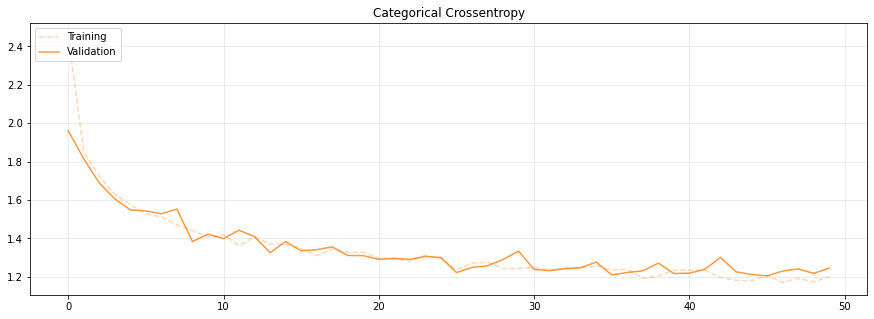

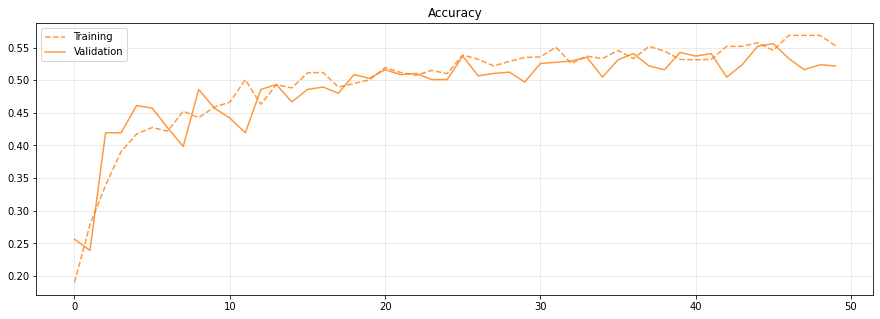

In [17]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.3, color='#ff7f0e', linestyle='--')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['categorical_accuracy'], label='Training', alpha=.8, color='#ff7f0e', linestyle='--')
plt.plot(history['val_categorical_accuracy'], label='Validation', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [18]:
# Save best epoch model
model.save("data_augmentation_experiments/CNN_NoAug_Best")

In [19]:
# Evaluate on test
# Trainined with no data augmentation
model_noaug = tfk.models.load_model("data_augmentation_experiments/CNN_NoAug_Best")
model_noaug_test_metrics = model_noaug.evaluate(test_gen, return_dict=True)


print()
print("Test metrics without data augmentation")
print(model_noaug_test_metrics)


46/46 [==============================] - 88s 2s/step - loss: 1.2529 - categorical_accuracy: 0.5374

Test metrics without data augmentation
{'loss': 1.2528549432754517, 'categorical_accuracy': 0.5373961329460144}


Accuracy: 0.5374
Precision: 0.5867
Recall: 0.5209
F1: 0.5303


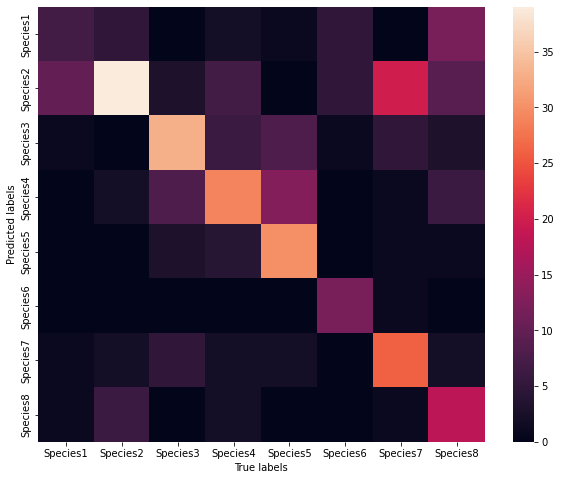

In [20]:
import seaborn as sns

predictions = model_noaug.predict_generator(test_gen, steps=224)
predicted_classes = np.argmax(predictions, axis=-1)

# Compute the confusion matrix
cm = (confusion_matrix(test_gen.classes, predicted_classes))

# Compute the classification metrics
accuracy = accuracy_score(test_gen.classes, predicted_classes)
precision = precision_score(test_gen.classes, predicted_classes, average='macro')
recall = recall_score(test_gen.classes, predicted_classes, average='macro')
f1 = f1_score(test_gen.classes, predicted_classes, average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

# Plot the confusion matrix
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()